# **1. Perkenalan Dataset**


### Pengenalan Dataset: `cryptonews.csv`

Dataset yang digunakan dalam eksperimen ini adalah `cryptonews.csv`, yang bersumber dari [Kaggle: Crypto News oleh Olivier Van Hiel](https://www.kaggle.com/datasets/oliviervha/crypto-news). Dataset ini berisi kumpulan berita terkait cryptocurrency yang dikumpulkan dari berbagai sumber berita kripto ternama seperti cryptonews.com, cryptopotato.com, dan cointelegraph.com, dalam rentang waktu lebih dari setahun (Oktober 2021 hingga Desember 2023). Analisis sentimen awal pada dataset ini telah dilakukan menggunakan TextBlob.

Dataset ini memiliki struktur yang rapi dengan beberapa kolom informatif, termasuk `date` (tanggal berita), `sentiment` (hasil analisis sentimen awal dari TextBlob), `source` (sumber berita), `subject` (subjek atau kategori berita), `text` (isi teks berita lengkap), `title` (judul berita), dan `url` (tautan ke berita asli). Untuk proyek ini, fokus utama akan diberikan pada kolom `text` sebagai input fitur dan kolom `sentiment` sebagai target label yang akan diproses lebih lanjut untuk membangun model analisis sentimen.

# **2. Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os

# NLTK for English text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# # Download required NLTK datasets if not already downloaded
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

# Handling class imbalance
from imblearn.over_sampling import SMOTE

# Label encoding and one-hot encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dewam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dewam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dewam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **3. Memuat Dataset**

In [2]:
file_path = '../cryptonews_raw/cryptonews.csv'

# Load the CSV file into a pandas DataFrame
try:
    df = pd.read_csv(file_path)
    print("File loaded successfully!")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")

File loaded successfully!


In [3]:
df.head()

,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31037 entries, 0 to 31036
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       31037 non-null  object
 1   sentiment  31037 non-null  object
 2   source     31037 non-null  object
 3   subject    31037 non-null  object
 4   text       31037 non-null  object
 5   title      31037 non-null  object
 6   url        31037 non-null  object
dtypes: object(7)
memory usage: 1.7+ MB


Dataset `cryptonews.csv` yang dimuat awalnya terdiri dari **31.037 baris (entri berita)** dan **7 kolom**. Semua kolom memiliki tipe data `object` (yang umumnya menandakan string di Pandas), dan tidak terdapat nilai kosong (non-null count sama dengan jumlah total baris) pada pemuatan awal ini. Penggunaan memori untuk dataset ini sekitar 1.7+ MB.

Berikut adalah rincian kolom yang ada:

*   **`date`**: Tanggal publikasi berita.
*   **`sentiment`**: Informasi sentimen awal yang terkait dengan berita (memerlukan parsing lebih lanjut).
*   **`source`**: Sumber atau platform berita.
*   **`subject`**: Subjek atau kategori utama dari berita.
*   **`text`**: Isi teks lengkap dari berita.
*   **`title`**: Judul berita.
*   **`url`**: Tautan ke sumber berita asli.

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

**Mengubah sentiment agar menjadi singkat untuk EDA**

In [ ]:
# Function to clean sentiment values
def clean_sentiment(text):
    text = text.lower()  # Make case-insensitive
    if 'negative' in text:
        return 'negative'
    elif 'positive' in text:
        return 'positive'
    elif 'neutral' in text:
        return 'neutral'
    else:
        return 'unknown'  # Or leave as is / handle missing

# Apply the function to sentiment column
df['clean_sentiment'] = df['sentiment'].apply(clean_sentiment)

# Show result
print(df)

                      date                                          sentiment  \
0      2023-12-19 06:40:41  {'class': 'negative', 'polarity': -0.1, 'subje...   
1      2023-12-19 06:03:24  {'class': 'neutral', 'polarity': 0.0, 'subject...   
2      2023-12-19 05:55:14  {'class': 'positive', 'polarity': 0.05, 'subje...   
3      2023-12-19 05:35:26  {'class': 'positive', 'polarity': 0.5, 'subjec...   
4      2023-12-19 05:31:08  {'class': 'neutral', 'polarity': 0.0, 'subject...   
...                    ...                                                ...   
31032  2021-10-27 15:17:00  {'class': 'neutral', 'polarity': 0.0, 'subject...   
31033  2021-10-19 13:39:00  {'class': 'positive', 'polarity': 0.1, 'subjec...   
31034  2021-10-18 13:58:00  {'class': 'positive', 'polarity': 0.14, 'subje...   
31035  2021-10-15 00:00:00  {'class': 'neutral', 'polarity': 0.0, 'subject...   
31036  2021-10-12 20:00:00  {'class': 'positive', 'polarity': 0.16, 'subje...   

              source     su

**Mengubah tipe data `date`**

In [6]:
# Convert 'date' to datetime (coerce handles invalid dates)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Show updated data types and sample
print(df.dtypes)

date               datetime64[ns]
sentiment                  object
source                     object
subject                    object
text                       object
title                      object
url                        object
clean_sentiment            object
dtype: object


C:\Users\dewam\AppData\Local\Temp\ipykernel_57980\1778409574.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='clean_sentiment', palette='viridis')


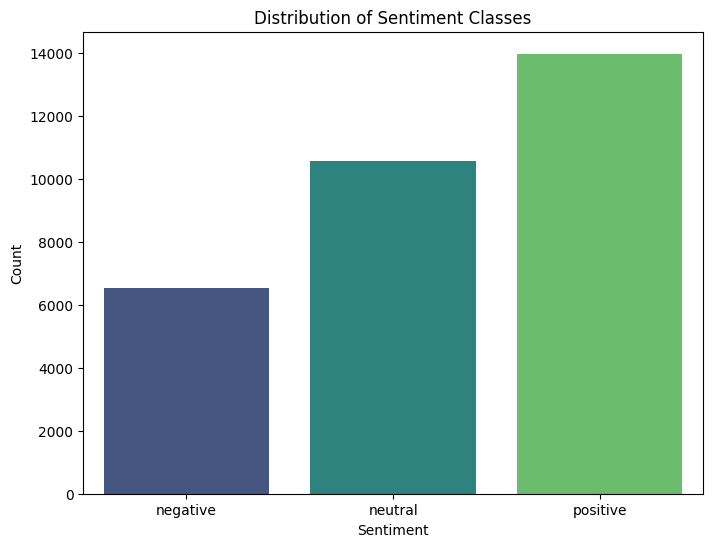

In [7]:
# Plot sentiment class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='clean_sentiment', palette='viridis')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Visualisasi di atas menunjukkan distribusi jumlah data untuk masing-masing kelas sentimen setelah dilakukan pemrosesan label. Dapat terlihat bahwa:

*   Kelas **`positive`** memiliki jumlah data terbanyak, dengan sekitar 14.000 sampel.
*   Kelas **`neutral`** berada di posisi kedua, dengan jumlah sekitar 10.500 sampel.
*   Kelas **`negative`** memiliki jumlah data paling sedikit, yaitu sekitar 6.500 sampel.

Distribusi ini menunjukkan adanya ketidakseimbangan kelas (class imbalance), di mana kelas `positive` lebih dominan dibandingkan dua kelas lainnya.

C:\Users\dewam\AppData\Local\Temp\ipykernel_57980\851941301.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sources.values, y=top_sources.index, palette='coolwarm')


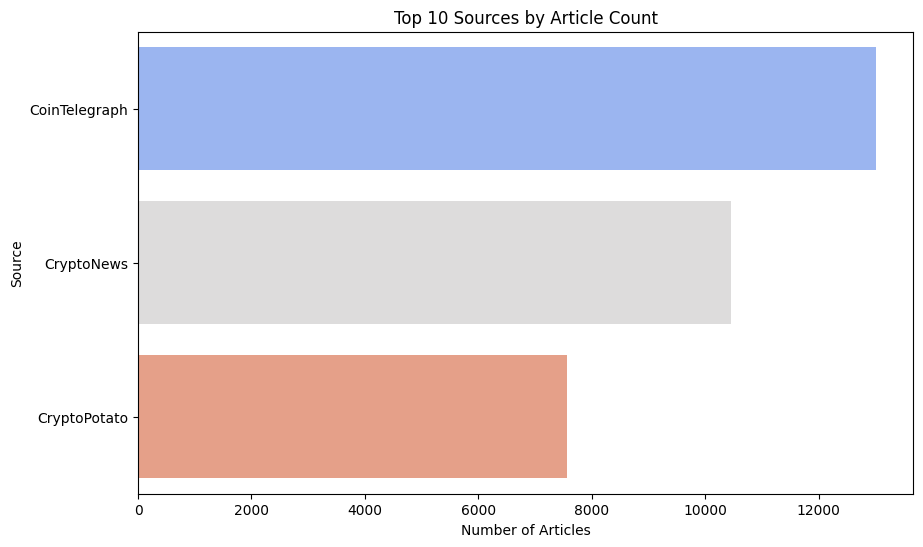

In [24]:
# Top 10 sources by article count
top_sources = df['source'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_sources.values, y=top_sources.index, palette='coolwarm')
plt.title('Top 10 Sources by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Source')
plt.show()

Visualisasi di atas menampilkan tiga sumber berita teratas berdasarkan jumlah artikel yang ada dalam dataset. Terlihat bahwa:

*   **CoinTelegraph** merupakan kontributor artikel terbanyak, dengan lebih dari 12.000 artikel.
*   **CryptoNews** berada di posisi kedua, menyumbang sekitar 10.000 artikel.
*   **CryptoPotato** menempati posisi ketiga, dengan jumlah artikel sekitar 7.500.

Distribusi ini menunjukkan bahwa sebagian besar data berasal dari CoinTelegraph.

C:\Users\dewam\AppData\Local\Temp\ipykernel_57980\2092337053.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_subjects.values, y=top_subjects.index, palette='magma')


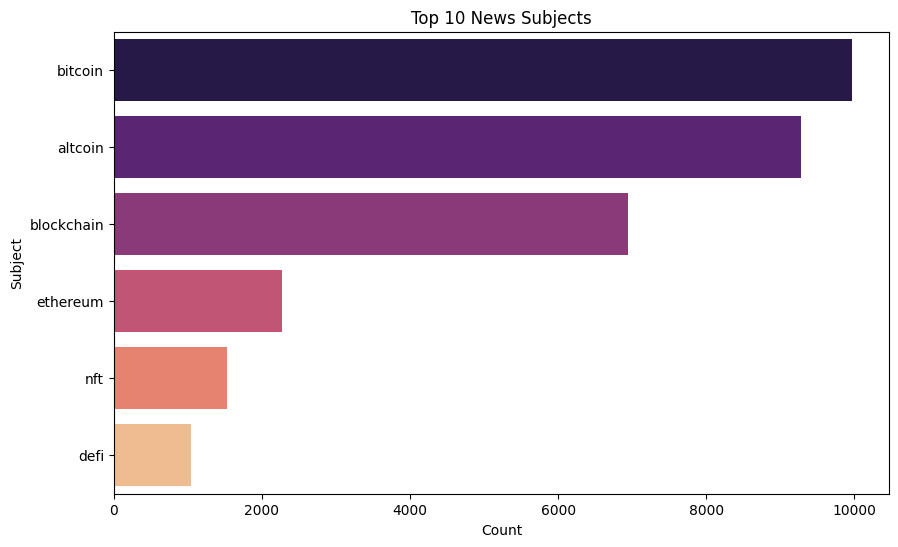

In [9]:
# Top 10 subjects
top_subjects = df['subject'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_subjects.values, y=top_subjects.index, palette='magma')
plt.title('Top 10 News Subjects')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.show()

Visualisasi di atas menampilkan sepuluh subjek berita yang paling sering muncul dalam dataset. Berdasarkan grafik, dapat diidentifikasi bahwa:

*   **Bitcoin** adalah subjek yang paling dominan, dengan hampir 10.000 artikel.
*   **Altcoin** mengikuti di posisi kedua dengan sekitar 9.500 artikel.
*   **Blockchain** menempati urutan ketiga dengan lebih dari 7.000 artikel.
*   Subjek lain seperti **Ethereum**, **NFT**, dan **DeFi** juga muncul dalam jumlah yang signifikan, meskipun lebih sedikit dibandingkan tiga teratas.

Distribusi ini memberikan gambaran tentang fokus utama pemberitaan dalam dataset. 

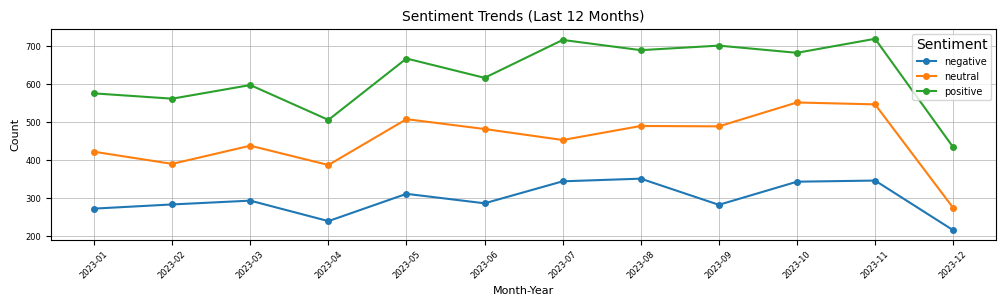

In [11]:
# Create month_year column first
df['month_year'] = df['date'].dt.to_period('M')

# Group by month-year and sentiment
time_trend = df.groupby(['month_year', 'clean_sentiment']).size().unstack(fill_value=0)

# Get last 12 months
time_trend = time_trend.sort_index().tail(12)

# Convert PeriodIndex to string for plotting
time_trend.index = time_trend.index.astype(str)

# Plot
plt.figure(figsize=(10, 3), dpi=100)

for i, sentiment in enumerate(time_trend.columns):
    plt.plot(
        time_trend.index,
        time_trend[sentiment],
        marker='o',
        label=sentiment,
        linewidth=1.5,
        markersize=4
    )

plt.title('Sentiment Trends (Last 12 Months)', fontsize=10)
plt.xlabel('Month-Year', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.legend(title='Sentiment', fontsize=7)
plt.grid(True, linewidth=0.5)
plt.xticks(rotation=45, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout(pad=0.5)
plt.show()

Grafik di atas menggambarkan tren jumlah berita untuk setiap kategori sentimen (negatif, netral, dan positif) selama periode 12 bulan terakhir (Januari 2023 hingga Desember 2023). Beberapa observasi penting dari tren ini adalah:

*   **Sentimen Positif (Hijau)**: Secara konsisten menunjukkan jumlah berita terbanyak dibandingkan dua sentimen lainnya hampir sepanjang tahun. Terdapat puncak signifikan sekitar pertengahan tahun (Mei hingga Juli 2023) dan menjelang akhir tahun (Oktober-November 2023), sebelum mengalami penurunan tajam di Desember 2023.
*   **Sentimen Netral (Oranye)**: Menunjukkan fluktuasi yang cukup stabil di pertengahan, dengan beberapa puncak kecil. Seperti sentimen positif, sentimen netral juga mengalami penurunan signifikan di Desember 2023.
*   **Sentimen Negatif (Biru)**: Umumnya memiliki jumlah berita paling sedikit. Trennya relatif datar dengan sedikit kenaikan di pertengahan tahun dan menjelang akhir tahun, sebelum akhirnya juga menurun di Desember 2023.

Secara keseluruhan, tren menunjukkan bahwa berita dengan sentimen positif paling mendominasi, namun semua kategori sentimen mengalami penurunan jumlah berita yang signifikan pada bulan Desember 2023.

C:\Users\dewam\AppData\Local\Temp\ipykernel_57980\3232555853.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='clean_sentiment', y='text_length', palette='viridis')


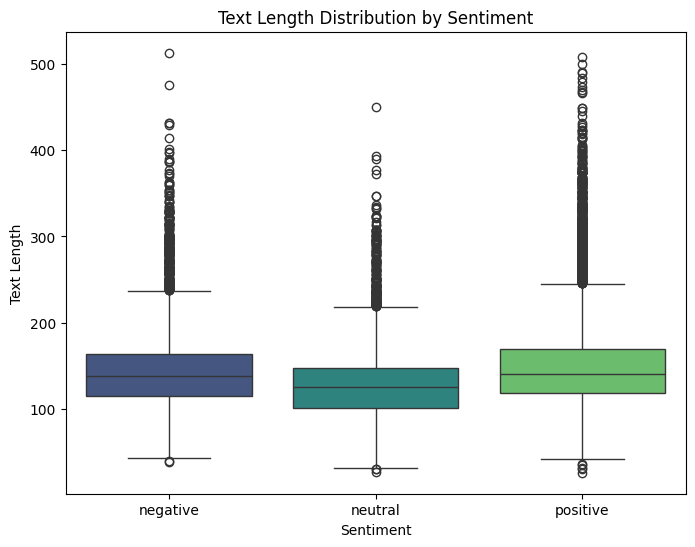

In [12]:
# Calculate text length
df['text_length'] = df['text'].str.len()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='clean_sentiment', y='text_length', palette='viridis')
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

Visualisasi boxplot di atas menunjukkan distribusi panjang teks (jumlah kata atau karakter, tergantung pada perhitungan `text_length`) untuk setiap kategori sentimen. Dari grafik ini, dapat diamati:

*   **Median Panjang Teks**:
    *   Berita dengan sentimen **`positive`** cenderung memiliki median panjang teks yang sedikit lebih tinggi dibandingkan dua kategori lainnya.
    *   Berita dengan sentimen **`neutral`** memiliki median panjang teks yang sedikit lebih rendah dari `positive` namun lebih tinggi dari `negative`.
    *   Berita dengan sentimen **`negative`** menunjukkan median panjang teks yang paling pendek di antara ketiganya.
*   **Variabilitas dan Outlier**:
    *   Ketiga kategori sentimen menunjukkan adanya sejumlah besar *outlier* (titik-titik di luar "whisker" boxplot), yang mengindikasikan adanya berita dengan panjang teks yang jauh lebih panjang dari mayoritas berita dalam kategori tersebut.
    *   Rentang interkuartil (IQR, panjang kotak) untuk sentimen `positive` dan `negative` terlihat sedikit lebih lebar dibandingkan `neutral`, menunjukkan variabilitas panjang teks yang sedikit lebih besar pada kedua kategori tersebut.

Meskipun ada perbedaan kecil pada median dan variabilitas, distribusi panjang teks antar kategori sentimen tidak menunjukkan perbedaan yang sangat drastis.

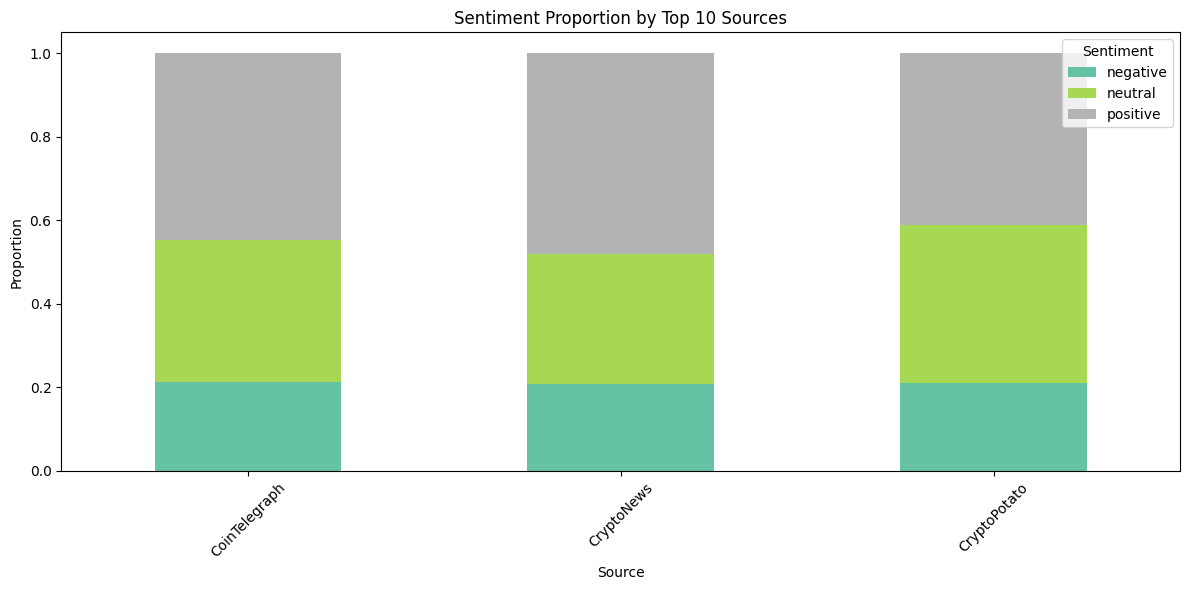

In [13]:
# Pivot table for source vs sentiment
source_sentiment = df.groupby(['source', 'clean_sentiment']).size().unstack(fill_value=0)

# Normalize by source
source_sentiment_norm = source_sentiment.div(source_sentiment.sum(axis=1), axis=0)

# Stacked bar chart
top_sources = source_sentiment_norm.loc[df['source'].value_counts().nlargest(10).index]
top_sources.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Sentiment Proportion by Top 10 Sources')
plt.xlabel('Source')
plt.ylabel('Proportion')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Visualisasi *stacked bar chart* di atas menunjukkan proporsi relatif dari sentimen negatif, netral, dan positif untuk tiga sumber berita teratas: CoinTelegraph, CryptoNews, dan CryptoPotato. Dari grafik ini, dapat diamati bahwa:

*   **Konsistensi Proporsi**: Ketiga sumber berita menunjukkan pola proporsi sentimen yang sangat mirip satu sama lain.
    *   Sentimen **negatif** (biru kehijauan) menyumbang sekitar 20-22% dari total artikel untuk masing-masing sumber.
    *   Sentimen **netral** (hijau kekuningan) merupakan proporsi terbesar kedua, berkisar antara 30-38%.
    *   Sentimen **positif** (abu-abu) memiliki proporsi tertinggi, sekitar 40-45% untuk setiap sumber.

*   **Tidak Ada Perbedaan Mencolok antar Sumber**: Berdasarkan visualisasi ini, tidak terlihat adanya perbedaan yang signifikan dalam distribusi proporsi sentimen antar ketiga sumber berita utama.

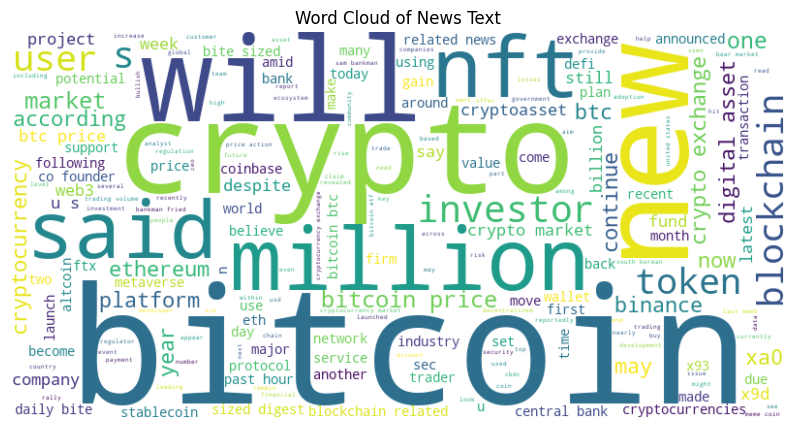

In [ ]:
# Combine all text
all_text = ' '.join(df['text'].str.lower())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of News Text')
plt.show()

Visualisasi *word cloud* di atas menampilkan kata-kata yang paling sering muncul dalam keseluruhan dataset teks berita. Ukuran kata merepresentasikan frekuensi kemunculannya.

Kata-kata dominan seperti **"crypto"**, **"bitcoin"**, **"will"**, **"nft"**, **"new"**, **"million"**, **"said"**, dan **"market"** menonjol, memberikan gambaran umum tentang topik utama dan terminologi yang umum digunakan dalam pemberitaan cryptocurrency. Ini mengonfirmasi bahwa dataset memang berfokus pada dunia aset digital dan perkembangannya.

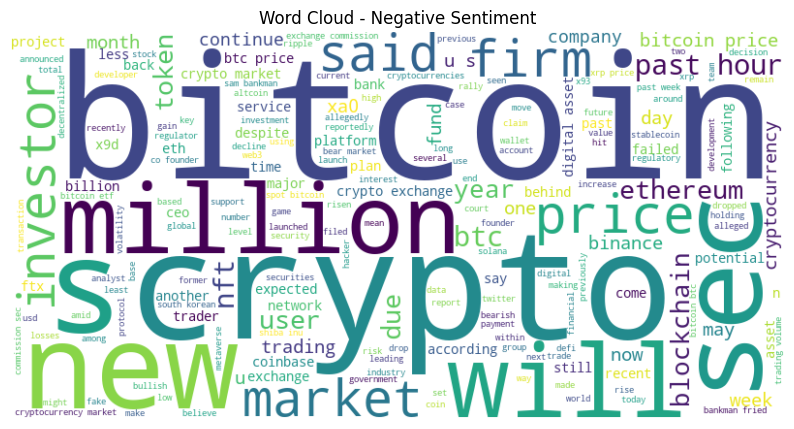

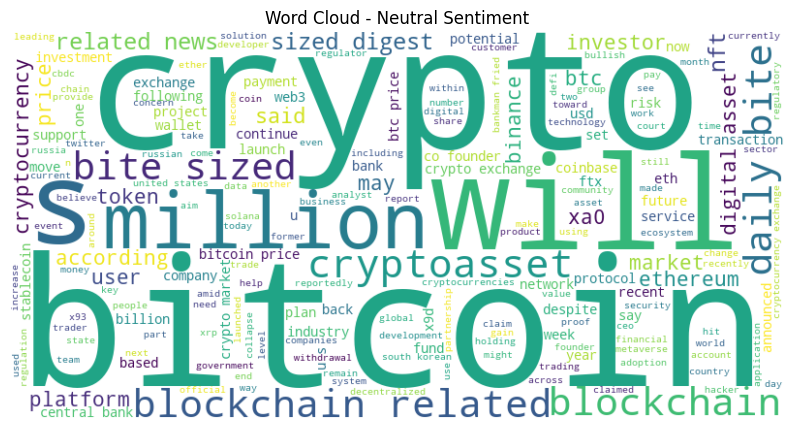

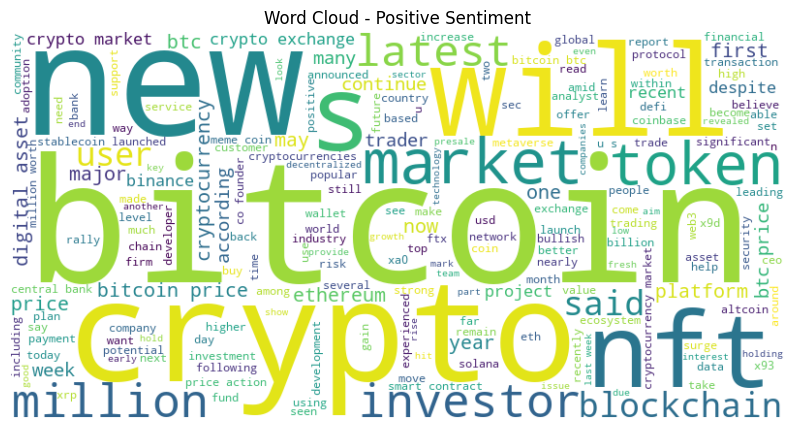

In [15]:
# Get unique sentiment classes
sentiments = df['clean_sentiment'].unique()

# Create and display a word cloud for each sentiment
for sentiment in sentiments:
    # Filter text by sentiment
    text_subset = ' '.join(df[df['clean_sentiment'] == sentiment]['text'].str.lower())
    
    if text_subset.strip() == '':
        print(f"No text found for '{sentiment}' sentiment.")
        continue
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_subset)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {sentiment.capitalize()} Sentiment')
    plt.axis("off")
    plt.show()

Visualisasi *word cloud* di atas menampilkan kata-kata yang paling sering muncul untuk masing-masing kategori sentimen: negatif, netral, dan positif.

*   **Sentimen Negatif**: Didominasi oleh kata-kata seperti **"bitcoin"**, **"crypto"**, **"million"**, **"firm"**, **"said"**, **"sec"**, dan **"price"**. Beberapa kata dengan konotasi kurang baik seperti "risk", "drop", "bear market", "hacker", "failed" juga muncul, mengindikasikan topik seputar penurunan harga, masalah keamanan, atau regulasi yang ketat.

*   **Sentimen Netral**: Kata-kata yang sering muncul antara lain **"crypto"**, **"bitcoin"**, **"will"**, **"million"**, **"said"**, **"blockchain"**, dan **"ftx"**. Word cloud ini menunjukkan campuran topik umum dalam berita kripto, seperti perkembangan teknologi, laporan pasar, dan nama-nama entitas besar tanpa penekanan kuat pada emosi tertentu.

*   **Sentimen Positif**: Didominasi oleh kata-kata seperti **"bitcoin"**, **"crypto"**, **"new"**, **"market"**, **"will"**, **"token"**, dan **"nft"**. Munculnya kata seperti "support", "gain", "launch", "growth", "bullish", dan "rally" menunjukkan fokus pada perkembangan positif, peluncuran baru, adopsi, dan potensi kenaikan harga.

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kami menggunakan data tidak terstruktur.

In [16]:
# Handle missing values
df = df.dropna(subset=['text'])

In [17]:
# Create clean text column and convert to lowercase
df['text_clean'] = df['text'].copy()
df['text_clean'] = df['text_clean'].apply(lambda x: str(x).lower())

In [18]:
# Function to clean text (remove emojis, special characters, numbers, and extra spaces)
def remove_special_characters(text):
    if isinstance(text, str):
        # Remove emojis using regex
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"  # alchemical symbols
            u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            u"\U0001F800-\U0001F8FF"  # Supplemental Symbols and Pictographs
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA00-\U0001FA6F"  # Chess symbols
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U00002702-\U000027B0"  # Dingbats
            u"\U000024C2-\U0001F251" 
            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        # Remove special characters and symbols (keep only letters)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    return text  # Return as-is if not a string

# Apply the cleaning function
df['text_clean'] = df['text_clean'].apply(remove_special_characters)

In [19]:
# Remove stopwords
st_words = stopwords.words('english')

def remove_stopwords(text):
    if isinstance(text, str):
        return ' '.join([w for w in text.split() if w not in st_words])
    return text

df['text_clean'] = df['text_clean'].apply(remove_stopwords)

In [20]:
# Tokenization
def tokenize_text(text):
    if not isinstance(text, str):
        return []
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

df['tokenized'] = df['text_clean'].apply(tokenize_text)

In [21]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# This will convert categorical sentiment labels into numerical values
df['sentiment_encoded'] = label_encoder.fit_transform(df['clean_sentiment'])

# Display the mapping between original labels and encoded values
sentiment_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nSentiment Encoding Mapping:")
for sentiment, code in sentiment_mapping.items():
    print(f"{sentiment}: {code}")

# Display sample results
print("\nSample Results:")
print(df[['clean_sentiment', 'sentiment_encoded']].head())


Sentiment Encoding Mapping:
negative: 0
neutral: 1
positive: 2

Sample Results:
  clean_sentiment  sentiment_encoded
0        negative                  0
1         neutral                  1
2        positive                  2
3        positive                  2
4         neutral                  1


In [22]:
# View data
df.head(10)

,date,sentiment,source,subject,text,title,url,clean_sentiment,month_year,text_length,text_clean,tokenized,sentiment_encoded
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...,negative,2023-12,125,grayscale ceo michael sonnenshein believes sec...,"[grayscale, ceo, michael, sonnenshein, believe...",0
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...,neutral,2023-12,207,exclusive interview cryptonews manhar garegrat...,"[exclusive, interview, cryptonews, manhar, gar...",1
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...,positive,2023-12,207,according federal court ruling december former...,"[according, federal, court, ruling, december, ...",2
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...,positive,2023-12,176,suggest evm inscriptions latest way retail acc...,"[suggest, evm, inscriptions, latest, way, reta...",2
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...,neutral,2023-12,130,decision bloxroute labs start censoring ofacsa...,"[decision, bloxroute, labs, start, censoring, ...",1
5,2023-12-19 05:25:00,"{'class': 'negative', 'polarity': -0.01, 'subj...",CryptoPotato,bitcoin,Yonsei found that during BTC’s rally in early ...,Is This Why Bitcoin’s Price Rally Was Halted? ...,https://cryptopotato.com/is-this-why-bitcoins-...,negative,2023-12,136,yonsei found btcs rally early december binary ...,"[yonsei, found, btcs, rally, early, december, ...",0
6,2023-12-19 04:50:11,"{'class': 'positive', 'polarity': 0.3, 'subjec...",CryptoNews,bitcoin,Cathie Wood led ARK Invest fund sold around 80...,Cathie Wood’s Ark Invest Sells $27.6 Million i...,https://cryptonews.comhttps://cryptonews.com/n...,positive,2023-12,121,cathie wood led ark invest fund sold around gr...,"[cathie, wood, led, ark, invest, fund, sold, a...",2
7,2023-12-19 04:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,Bitcoin's 150% surge pales in comparison to th...,Bitcoin Soared 150% in 2023 But These Companie...,https://cryptopotato.com/bitcoin-soared-150-in...,neutral,2023-12,129,bitcoins surge pales comparison staggering ret...,"[bitcoins, surge, pales, comparison, staggerin...",1
8,2023-12-19 04:00:01,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,The South Korean city of Busan is edging close...,South Korean City Busan Names Digital Exchange...,https://cryptonews.comhttps://cryptonews.com/n...,neutral,2023-12,165,south korean city busan edging closer launch l...,"[south, korean, city, busan, edging, closer, l...",1
9,2023-12-19 02:59:59,"{'class': 'negative', 'polarity': -0.08, 'subj...",CoinTelegraph,bitcoin,The SEC has pushed back its decision on a rost...,"SEC delays several Ethereum ETFs, pushing fina...",https://cointelegraph.com/news/sec-delays-ethe...,negative,2023-12,133,sec pushed back decision roster ethereum etfs ...,"[sec, pushed, back, decision, roster, ethereum...",0


In [23]:
# Select only the necessary columns
columns_to_save = [
    'date',          
    'source',
    'subject',
    'title',
    'text_clean',
    'tokenized',
    'clean_sentiment',
    'sentiment_encoded' 
]

# Filter DataFrame
df_filtered = df[columns_to_save]

# Define save path
save_path = 'cryptonews_preprocessing/preprocessed_cryptonews.csv'

# Ensure directory exists
os.makedirs('cryptonews_preprocessing', exist_ok=True)

# Save the filtered DataFrame
df_filtered.to_csv(save_path, index=False)

# Display sample results
print("\nPreprocessing Results Sample:")
for i in range(3):
    print(f"\nOriginal Text: {df['text'].iloc[i][:100]}...")
    print(f"Cleaned Text: {df_filtered['text_clean'].iloc[i][:100]}...")
    print(f"Tokens: {df_filtered['tokenized'].iloc[i][:10]}...")

print(f"\nPreprocessed data saved to: {os.path.abspath(save_path)}")


Preprocessing Results Sample:

Original Text: Grayscale CEO Michael Sonnenshein believes the SEC needs to approve spot Bitcoin exchange-traded fun...
Cleaned Text: grayscale ceo michael sonnenshein believes sec needs approve spot bitcoin exchangetraded funds etfs ...
Tokens: ['grayscale', 'ceo', 'michael', 'sonnenshein', 'believes', 'sec', 'needs', 'approve', 'spot', 'bitcoin']...

Original Text: In an exclusive interview with CryptoNews, Manhar Garegrat, the Country Head for India and Global Pa...
Cleaned Text: exclusive interview cryptonews manhar garegrat country head india global partnerships liminal custod...
Tokens: ['exclusive', 'interview', 'cryptonews', 'manhar', 'garegrat', 'country', 'head', 'india', 'global', 'partnerships']...

Original Text: According to the Federal Court ruling on December 18, former Binance CEO Changpeng 'CZ' Zhao has bee...
Cleaned Text: according federal court ruling december former binance ceo changpeng cz zhao ordered pay million bin...
Tokens: ['a